The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating Epoch 1/10: 100%|██████████| 9/9 [01:20<00:00,  8.98s/it]


Epoch 1 - Train Loss: 2.4083, Val Loss: 2.2459, Train Acc: 0.2183, Val Acc: 0.3077


Validating Epoch 2/10: 100%|██████████| 9/9 [01:18<00:00,  8.73s/it]


Epoch 2 - Train Loss: 2.0237, Val Loss: 1.9362, Train Acc: 0.3923, Val Acc: 0.3692


Validating Epoch 3/10: 100%|██████████| 9/9 [01:21<00:00,  9.02s/it]


Epoch 3 - Train Loss: 1.6858, Val Loss: 1.6373, Train Acc: 0.4904, Val Acc: 0.4615


Validating Epoch 4/10: 100%|██████████| 9/9 [01:19<00:00,  8.78s/it]


Epoch 4 - Train Loss: 1.3934, Val Loss: 1.4947, Train Acc: 0.5548, Val Acc: 0.5077


Validating Epoch 5/10: 100%|██████████| 9/9 [01:19<00:00,  8.78s/it]


Epoch 5 - Train Loss: 1.1746, Val Loss: 1.4679, Train Acc: 0.6087, Val Acc: 0.4923


Validating Epoch 6/10: 100%|██████████| 9/9 [01:20<00:00,  8.94s/it]


Epoch 6 - Train Loss: 1.0467, Val Loss: 1.3644, Train Acc: 0.6385, Val Acc: 0.5077


Validating Epoch 7/10: 100%|██████████| 9/9 [01:18<00:00,  8.75s/it]


Epoch 7 - Train Loss: 0.9306, Val Loss: 1.3646, Train Acc: 0.6567, Val Acc: 0.4923


Validating Epoch 8/10: 100%|██████████| 9/9 [01:19<00:00,  8.78s/it]


Epoch 8 - Train Loss: 0.8627, Val Loss: 1.3263, Train Acc: 0.6769, Val Acc: 0.5346


Validating Epoch 9/10: 100%|██████████| 9/9 [01:20<00:00,  8.96s/it]


Epoch 9 - Train Loss: 0.7875, Val Loss: 1.2784, Train Acc: 0.6817, Val Acc: 0.4615


Validating Epoch 10/10: 100%|██████████| 9/9 [01:19<00:00,  8.87s/it]


Epoch 10 - Train Loss: 0.7271, Val Loss: 1.2836, Train Acc: 0.7000, Val Acc: 0.4808


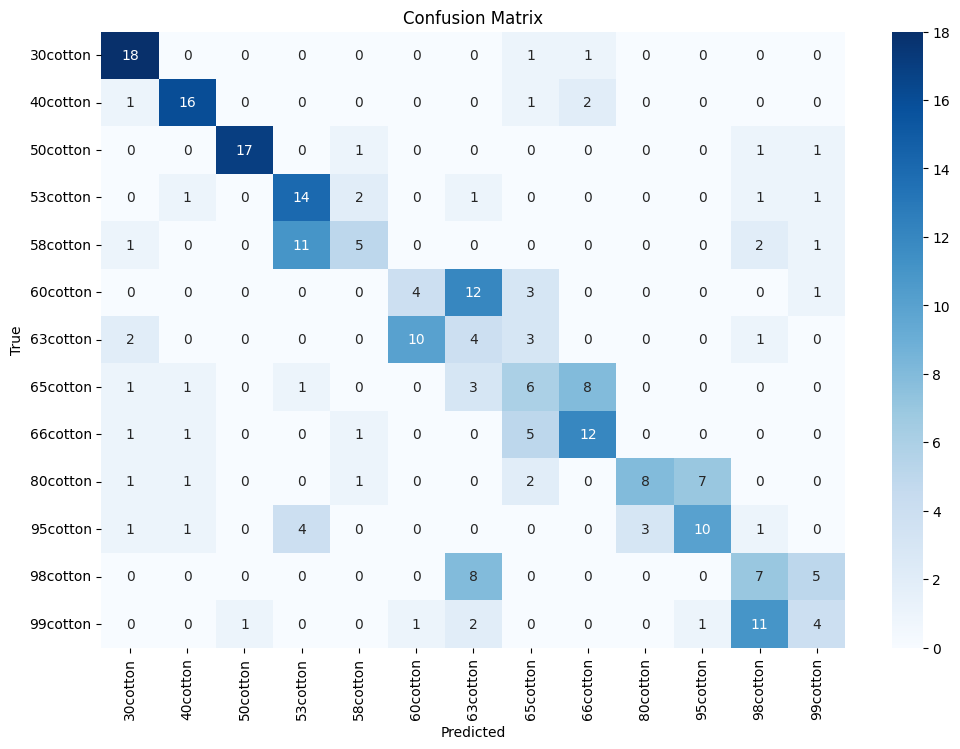

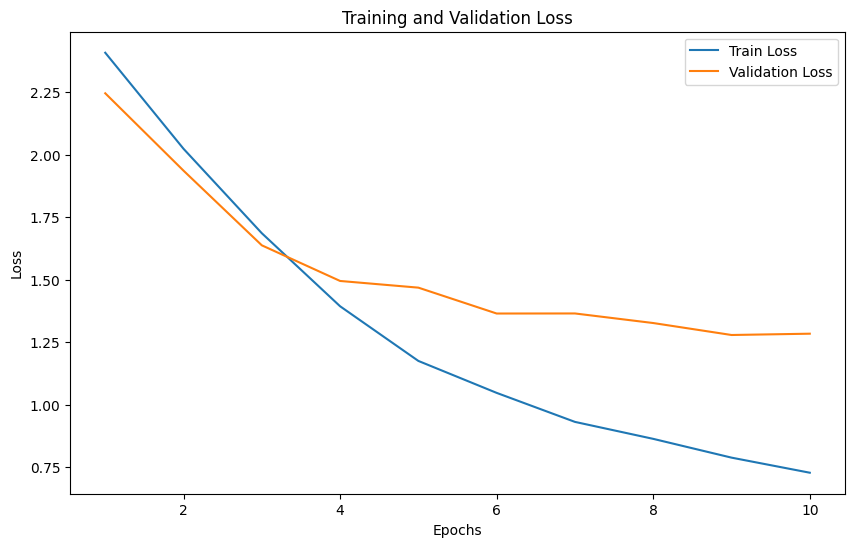

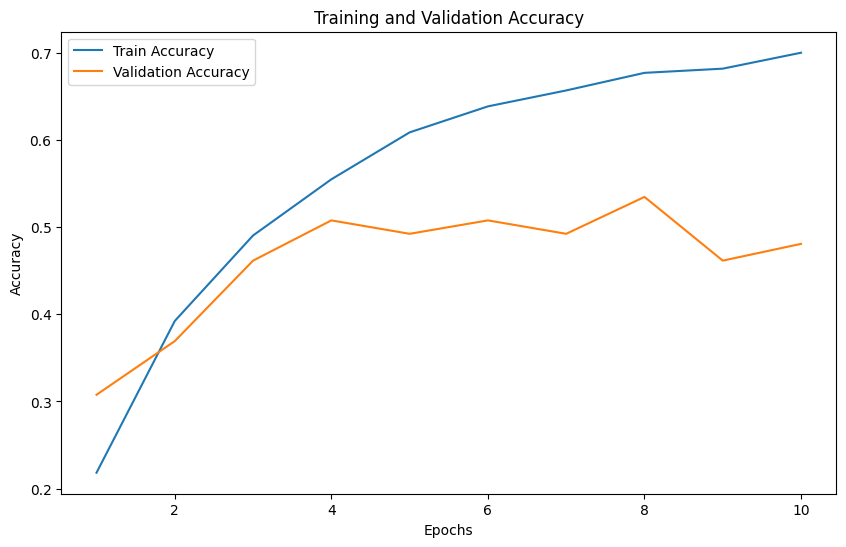

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# Dataset class
class CottonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            image = self.transform(image)

        return image, label

# Define augmentation transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset path
data_dir = r"C:\Users\User\Downloads\Original\Original"

# Split data into train and validation sets
all_image_paths = []
all_labels = []
class_names = sorted(os.listdir(data_dir))

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        if os.path.isfile(img_path):
            all_image_paths.append(img_path)
            all_labels.append(label)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

class SplitCottonDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = SplitCottonDataset(train_paths, train_labels, transform=train_transform)
val_dataset = SplitCottonDataset(val_paths, val_labels, transform=val_transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load Pretrained ViT Model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(class_names)
)

# Device and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training and Evaluation Function
def train_model_with_plots(model, train_loader, val_loader, criterion, optimizer, epochs=10, save_dir="./saved_models"):
    os.makedirs(save_dir, exist_ok=True)

    # Metrics storage
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        # Save the model
        torch.save(model.state_dict(), os.path.join(save_dir, f"vit_model_epoch_{epoch+1}.pth"))
        print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    # Final confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Start training
train_model_with_plots(model, train_loader, val_loader, criterion, optimizer, epochs=10, save_dir=r"C:\Users\User\Downloads\Original")
